In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


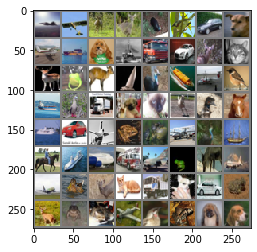

plane plane deer  deer  bird  bird  car   dog   plane ship  dog   ship  truck car   deer  cat   deer  frog  deer  ship  bird  ship  plane bird  ship  bird  truck dog   cat   horse bird  horse ship  car   plane frog  frog  plane bird  ship  horse ship  plane truck plane frog  deer  plane plane bird  deer  cat   truck dog   car   frog  deer  frog  cat   plane bird  frog  dog   dog  


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

Using cuda device


In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [55]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   101] loss: 0.044
[1,   201] loss: 0.045
[1,   301] loss: 0.045
[1,   401] loss: 0.046
[1,   501] loss: 0.045
[1,   601] loss: 0.046
[1,   701] loss: 0.047
[2,     1] loss: 0.000
[2,   101] loss: 0.045
[2,   201] loss: 0.045
[2,   301] loss: 0.045
[2,   401] loss: 0.046
[2,   501] loss: 0.046
[2,   601] loss: 0.044


KeyboardInterrupt: 

In [56]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

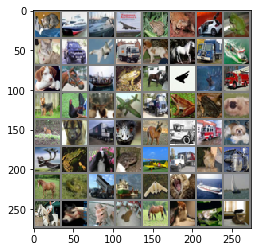

GroundTruth:  cat   ship  ship  plane


In [57]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [58]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [59]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [60]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.4 %
Accuracy for class: car   is 79.1 %
Accuracy for class: bird  is 49.3 %
Accuracy for class: cat   is 44.2 %
Accuracy for class: deer  is 55.5 %
Accuracy for class: dog   is 45.0 %
Accuracy for class: frog  is 71.9 %
Accuracy for class: horse is 65.2 %
Accuracy for class: ship  is 73.4 %
Accuracy for class: truck is 69.5 %


In [22]:
params = list(net.parameters())

torch.Size([6, 3, 5, 5])

In [27]:
net.conv1.weight[0]

tensor([[[ 0.0174,  0.2107,  0.3545,  0.3745,  0.5436],
         [ 0.1301,  0.2494,  0.4270,  0.2169,  0.2161],
         [ 0.0546,  0.2142,  0.2679, -0.0373, -0.0180],
         [ 0.0343,  0.1077, -0.2319, -0.3718,  0.0405],
         [-0.1698, -0.3427, -0.3235, -0.2909,  0.1148]],

        [[-0.4193, -0.2145, -0.0909, -0.1436, -0.3393],
         [-0.2374, -0.0418,  0.0163, -0.3005, -0.3810],
         [-0.0025, -0.0258, -0.0656, -0.4794, -0.4247],
         [ 0.1560,  0.0387, -0.3311, -0.4726, -0.1237],
         [ 0.0730, -0.1510, -0.2562, -0.2500,  0.2085]],

        [[-0.1342,  0.0087, -0.0317, -0.0963, -0.0697],
         [-0.0395,  0.2039,  0.0526, -0.0517, -0.0117],
         [ 0.1659,  0.3317,  0.1962, -0.2011,  0.1486],
         [ 0.1618,  0.1238,  0.0452, -0.3276,  0.1570],
         [ 0.1088,  0.0896, -0.0847,  0.0662,  0.4179]]], device='cuda:0',
       grad_fn=<SelectBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


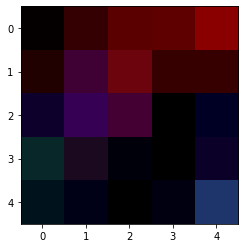

In [35]:
net1 = net.conv1.weight[0].clone().cpu().detach().numpy()

plt.imshow(np.transpose(net1, (1, 2, 0)))

In [36]:
net1

array([[[ 0.01735301,  0.21070503,  0.35451555,  0.37454823,
          0.5435683 ],
        [ 0.13011667,  0.24939534,  0.4269713 ,  0.21692376,
          0.21606325],
        [ 0.05458454,  0.21417436,  0.26789522, -0.03730907,
         -0.0179503 ],
        [ 0.0342507 ,  0.10771608, -0.23193695, -0.37181368,
          0.04048867],
        [-0.16980433, -0.34274086, -0.32353935, -0.29090843,
          0.1147518 ]],

       [[-0.41926637, -0.21445052, -0.09089191, -0.14355637,
         -0.3393021 ],
        [-0.23743096, -0.0417665 ,  0.01627471, -0.30048782,
         -0.38100395],
        [-0.0024662 , -0.02582088, -0.06564051, -0.47935906,
         -0.42473996],
        [ 0.15601768,  0.03871617, -0.33114666, -0.47255653,
         -0.12366226],
        [ 0.0730309 , -0.15095022, -0.25622594, -0.24998313,
          0.20848465]],

       [[-0.13417931,  0.00868572, -0.03172519, -0.09625947,
         -0.06969056],
        [-0.03954976,  0.20386171,  0.05256024, -0.05167649,
         -0

In [40]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

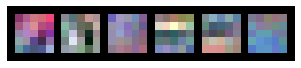

In [44]:
f = net.conv1.weight.data.clone().cpu()
visTensor(f, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [61]:
net.conv1.weight.shape

torch.Size([6, 3, 5, 5])